## Notebook for Generation of Figures for In-Depth Analysis in Section 4.1

Import packages

In [1]:
import json
import logging
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns

from matplotlib.ticker import MaxNLocator

pd.options.mode.chained_assignment = None

Initiate variables

In [2]:
x_plot = np.arange(0, 1, 0.001)
x_plot50 = np.arange(0, 50, 0.01)

# Evaluation measures
sr_eval = ["crps", "me", "lgt", "cov"]

# Skill scores
sr_skill = ["crps"]

# Names of aggregation methods
agg_names = {
    "lp": "Linear Pool",
    "vi": "Vincentization",
    "vi-a": "Vincentization (a)",
    "vi-w": "Vincentization (w)",
    "vi-aw": "Vincentization (a, w)",
}
agg_abr = {
    "lp": r"LP",
    "vi": r"$V_0^=$",
    "vi-a": r"$V_a^=$",
    "vi-w": r"$V_0^w$",
    "vi-aw": r"$V_a^w$",
}

# Aggregation methods
agg_meths = list(agg_names.keys())

# Methods with coefficient estimation
coeff_meths = ["vi-a", "vi-w", "vi-aw"]

# Get colors
cols = sns.color_palette("Dark2", 8, as_cmap=True)

# Colors of aggregation methods
agg_col = {
    "lp": cols.colors[5],  # type: ignore
    "vi": cols.colors[4],  # type: ignore
    "vi-a": cols.colors[0],  # type: ignore
    "vi-w": cols.colors[2],  # type: ignore
    "vi-aw": cols.colors[3],  # type: ignore
    "ens": cols.colors[7],  # type: ignore
    "opt": cols.colors[6],  # type: ignore
}

# Colors with full names
agg_col_names = {agg_names[key]: value for key, value in agg_col.items() if key in agg_names}

# Line types of aggregation methods
agg_lty = {
    "lp": "dashed",
    "vi": "solid",
    "vi-a": "solid",
    "vi-w": "solid",
    "vi-aw": "solid",
    "ens": "dashdot",
    "opt": "dashdot",
}

# Names of datasets
set_names = {
    "gusts": "Wind",
    "scen_1": "Scenario 1",
    "scen_4": "Scenario 2",
    "protein": "Protein",
    "naval": "Naval",
    "power": "Power",
    "kin8nm": "Kin8nm",
    "wine": "Wine",
    "concrete": "Concrete",
    "energy": "Energy",
    "boston": "Boston",
    "yacht": "Yacht",
}

# Names of ensemble methods
ens_names = {
    "rand_init": "Random Initialization",
    "bagging": "Bagging",
    "batchensemble": "BatchEnsemble",
    "mc_dropout": "MC Dropout",
    "variational_dropout": "Variational Dropout",
    "concrete_dropout": "Concrete Dropout",
    "bayesian": "Bayesian",
}

# Abbrevaitions of ensemble methods
ens_abbr = {
    "rand_init": "Naive Ens.\\",
    "bagging": "Bagging",
    "batchensemble": "BatchEns.\\",
    "mc_dropout": "MC Dropout",
    "variational_dropout": "Var.\\ Dropout",
    "concrete_dropout": "Conc.\\ Dropout",
    "bayesian": "Bayesian",
}

Function for configuration data (Requires to set GIT-Path!)

In [3]:
# Set GIT-path
git_path = "path_to_repo"

# Configuration function
def _get_config_info(ens_method):
    ### Get Config ###
    with open(f"{git_path}/src/config_eval.json", "rb") as f:
        CONFIG = json.load(f)
    
    # Get available ensemble methods
    ens_method_ls = CONFIG["_available_ENS_METHOD"]
    
    # Path for figures
    plot_path = os.path.join(
        CONFIG["PATHS"]["GIT_DIR"],
        CONFIG["PATHS"]["PLOTS_DIR"],
        "in_depth",
    )

    # Path of data
    data_path = os.path.join(
        CONFIG["PATHS"]["DATA_DIR"],
        CONFIG["PATHS"]["RESULTS_DIR"],
        "dataset",
        ens_method,
    )

    # Path of network ensemble data
    data_ens_path = os.path.join(
        CONFIG["PATHS"]["DATA_DIR"],
        CONFIG["PATHS"]["RESULTS_DIR"],
        "dataset",
        ens_method,
        CONFIG["PATHS"]["ENSEMBLE_F"],
    )

    # Path of aggregated network data
    data_agg_path = os.path.join(
        CONFIG["PATHS"]["DATA_DIR"],
        CONFIG["PATHS"]["RESULTS_DIR"],
        "dataset",
        ens_method,
        CONFIG["PATHS"]["AGG_F"],
    )

    # Models considered
    dataset_ls = CONFIG["DATASET"]

    # Number of simulations
    n_sim = CONFIG["PARAMS"]["N_SIM"]

    # Ensemble size
    n_ens = CONFIG["PARAMS"]["N_ENS"]
    # Vector of ensemble members
    step_size = 2
    n_ens_vec = np.arange(
        start=step_size, stop=n_ens + step_size, step=step_size
    )

    # Network variants
    nn_vec = CONFIG["PARAMS"]["NN_VEC"]

    return (
        ens_method,
        ens_method_ls,
        plot_path,
        data_path,
        data_ens_path,
        data_agg_path,
        dataset_ls,
        n_sim,
        n_ens,
        n_ens_vec,
        nn_vec,
    )

Load evaluation data for generation of figures

In [4]:
with open(f"{git_path}/src/paper_figures_data.pkl", "rb") as f:
    df_plot = pickle.load(f)

### Kin8nm - Bayesian

Get configuration data

In [5]:
(
        ens_method,
        ens_method_ls,
        plot_path,
        data_path,
        data_ens_path,
        data_agg_path,
        dataset_ls,
        n_sim,
        n_ens,
        n_ens_vec,
        nn_vec,
    ) = _get_config_info(ens_method="bayesian")

In [6]:
# Get exemplary score file
dataset = "kin8nm"
ens_method = "bayesian"

# Replace ensemble method (required as data_path depends on last ens. method called)
for temp_ens_method in ens_method_ls:
    data_path = data_path.replace(temp_ens_method, ens_method)

# Load scores
filename = f"eval_{dataset}_{ens_method}.pkl"
temp_data_path = data_path.replace("dataset", dataset)
with open(os.path.join(temp_data_path, filename), "rb") as f:
    df_scores = pickle.load(f) 

Generate score panel

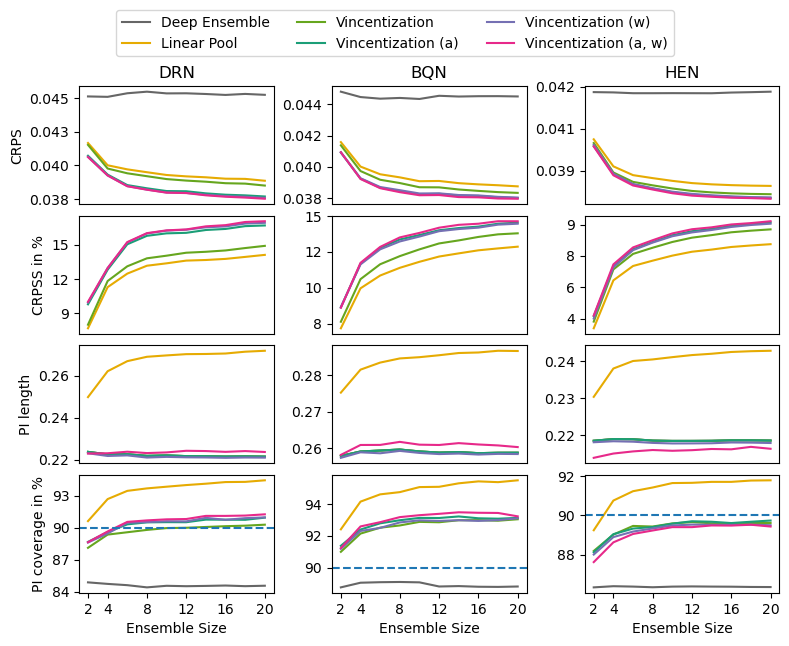

In [7]:
def plot_panel_model(
        crps_tick = 3,
        crpss_tick = 0,
        lgt_tick = 2,
        cov_tick = 0,
        y_bins = 4,
):
    ### Get CONFIG information ###
    (
        _,
        _,
        plot_path,
        _,
        _,
        _,
        _,
        n_sim,
        _,
        n_ens_vec,
        nn_vec,
    ) = _get_config_info(ens_method=ens_method)

    ### Simulation: Score panel ###
    # Vector of scores/quantiles to plot
    score_vec = ["crps", "crpss", "lgt", "cov"]

    ### Initialization ###
    # Only scenario
    df_sc = df_scores[df_scores["model"] == dataset]

    ### Calculate quantities ###
    df_plot = pd.DataFrame()

    # For-Loop over quantities of interest
    for temp_sr in score_vec:
        # Consider special case CRPSS
        if temp_sr == "crpss":
            temp_out = "crps"
        else:
            temp_out = temp_sr

        # Get optimal score of scenario for CRPSS
        s_opt = 0
        
        # For-Loop over network variants
        for temp_nn in nn_vec:
            # Only network type
            df_nn = df_sc[df_sc["nn"] == temp_nn]

            # For-Lop over ensemble sizes and aggregation methods
            for i_ens in n_ens_vec:
                for temp_agg in ["opt", "ens"] + agg_meths:
                    # Skip ensemble for skill
                    if (temp_sr == "crpss") and (temp_agg == "ens"):
                        continue
                    elif (temp_sr == "crpss") and (temp_agg == "opt"):
                        continue
                    elif (temp_sr == "a") and (temp_agg == "opt"):
                        continue
                    elif (temp_sr == "w") and (temp_agg == "opt"):
                        continue

                    # Fill in data frame
                    new_row = {
                        "nn": temp_nn,
                        "metric": temp_sr,
                        "n_ens": i_ens,
                        "agg": temp_agg,
                    }

                    # Reference: Average score of ensemble members
                    s_ref = df_nn[
                        (df_nn["n_rep"] < i_ens) # n_rep starts at 0!!
                        & (df_nn["type"] == "ind")
                    ][temp_out].mean()

                    # Special case: Average ensemble score
                    if temp_agg == "ens":
                        new_row["score"] = s_ref
                    elif temp_agg == "opt":
                        new_row["score"] = s_opt
                    else:
                        # Read out score
                        new_row["score"] = df_nn[
                            (df_nn["n_ens"] == i_ens)
                            & (df_nn["type"] == temp_agg)
                        ][temp_out].mean()

                        # Special case: CRPSS
                        if temp_sr == "crpss":
                            # Calcuate skill
                            new_row["score"] = (
                                100
                                * (s_ref - new_row["score"])
                                / (s_ref - s_opt)
                            )

                        # Relative weight difference to equal weights in %
                        if temp_sr == "w":
                            new_row["score"] = 100 * (
                                i_ens * new_row["score"] - 1
                            )

                    df_plot = pd.concat(
                        [
                            df_plot,
                            pd.DataFrame(new_row, index=[0]),
                        ],
                        ignore_index=True,
                    )

    ### Prepare data ###
    # Rename networks
    df_plot["nn"] = df_plot["nn"].str.upper()
    
    # Rename metrics
    score_labels = {
        "crps": "CRPS",
        "crpss": "CRPSS in %",
        "lgt": "PI length",
        "cov": "PI coverage in %",
    }

    # Intercept values
    hline_vec0 = {
        "cov": 90,
    }

    # Legend labels
    leg_labels = {"ens": "Deep Ensemble", **agg_names}

    ### PDF ###
    fig, axes = plt.subplots(
        len(score_labels),
        len(nn_vec),
        figsize=(8, 6),
        squeeze=False,  # Always return 2d array even if only 1d
    )

    # Exclude optimal forecasts
    df_plot = df_plot[df_plot["agg"] != "opt"]

    # For-Loop over networks
    for i, temp_nn in enumerate([x.upper() for x in nn_vec]):
        # Horizontal line
        if any(
            (df_plot["nn"] == temp_nn)
            & (df_plot["metric"] == "crpss")
            & (df_plot["score"] <= 0)
        ):
            hline_vec = {"crpss": 0, **hline_vec0}
        else:
            hline_vec = hline_vec0

        # Display y-label?
        y_label = True
        if i > 0:
            y_label = False

        # For-Loop over metrics
        for j, metric in enumerate(score_labels.keys()):
            # Display x-label
            x_label = False
            if j == (len(score_labels) - 1):
                x_label = True
            
            # Lineplot of score
            sns.lineplot(
                ax=axes[j][i],
                data=df_plot[
                    (df_plot["nn"] == temp_nn)
                    & (df_plot["metric"] == metric)
                ],
                x="n_ens",
                y="score",
                hue="agg",
                palette=agg_col,
            )
            
            # Show benchmark
            if metric in hline_vec.keys():
                axes[j][i].axhline(y=hline_vec[metric], linestyle="dashed")
            
            # Show y-label
            if y_label:
                axes[j][i].set_ylabel(score_labels[metric])
            else:
                axes[j][i].set_ylabel("")
            
            # Show x-label
            if x_label:
                axes[j][i].set_xlabel("Ensemble Size")
            else:
                axes[j][i].set_xlabel("")
            
            # Show title
            if j == 0:
                axes[j][i].title.set_text(temp_nn)  # type: ignore
            
            # Choose decimals
            if metric == "crps": f_ticks = crps_tick
            elif metric == "crpss": f_ticks = crpss_tick
            elif metric == "lgt": f_ticks = lgt_tick
            elif metric == "cov": f_ticks = cov_tick

            # Set decimals on y-axis
            axes[j][i].yaxis.set_major_formatter(mtick.FormatStrFormatter(f'%.{f_ticks}f'))

            # Set number of ticks on y-axis
            axes[j][i].yaxis.set_major_locator(MaxNLocator(nbins=y_bins))
            
            # Set ticks on x-axis
            axes[j][i].set_xticks([2, 4, 8, 12, 16, 20])
            
            # Omit ticks on x-axis on upper rows
            if j != (len(score_labels) - 1):
                axes[j][i].set_xticks([])

    # Create legend
    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(
        handles,
        [leg_labels[label] for label in labels],
        loc="upper center",
        ncol = 3,
        bbox_to_anchor=(0.5, 1.08), 
    )
    
    # No other legend shown
    for ax in axes.flatten():  # type: ignore
        ax.legend().set_visible(False)

    # Optimize layout automatically
    plt.tight_layout()

    # Adjust horizontal/vertical spaces in subplot
    plt.subplots_adjust(wspace=0.30)
    plt.subplots_adjust(hspace=0.10)
    
    # Show plot
    plt.show()
    
    # Save fig
    filename = os.path.join(plot_path, f"{dataset}_{ens_method}_panel.pdf")
    fig.savefig(filename, bbox_inches="tight")
    log_message = f"Panel saved to {filename}"
    logging.info(log_message)
    plt.close(fig)

# Execute function
plot_panel_model()

Generate PIT histograms

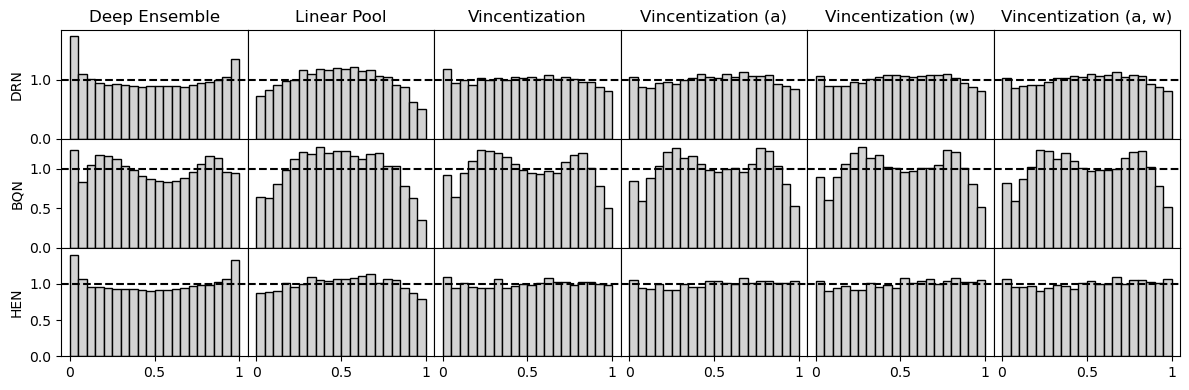

In [8]:
def plot_pit_ens(n_ens = 10, n_bins = 20):
    ### Get CONFIG information ###
    (
        _,
        _,
        plot_path,
        _,
        data_ens_path,
        data_agg_path,
        _,
        n_sim,
        _,
        _,
        nn_vec,
    ) = _get_config_info(ens_method=ens_method)

    ### Simulation: PIT histograms ###
    # Get number of repetitions
    if dataset in ["gusts", "protein", "year"]:
        temp_n_sim = 5
    else:
        temp_n_sim = n_sim
    
    ### Get PIT values ###
    # List for PIT values
    pit_ls = {}

    # For-Loop over network variants
    for temp_nn in nn_vec:
        ### PIT values of ensemble member ###
        # Vector for PIT values
        temp_pit = []

        # For-Loop over ensemble member and simulation
        for i_rep in range(n_ens):
            for i_sim in range(temp_n_sim):
                # Load ensemble member
                filename = (
                    f"{temp_nn}_sim_{i_sim}_ens_{i_rep}.pkl"  # noqa: E501
                )
                temp_data_ens_path = data_ens_path.replace(
                    "dataset", dataset
                )
                with open(
                    os.path.join(temp_data_ens_path, filename), "rb"
                ) as f:
                    [pred_nn, y_valid, y_test] = pickle.load(f)
                
                # Check
                if np.isnan(pred_nn["scores"]["pit"]).any():
                    log_message = f"NaN in PIT detected in {filename}"
                    logging.info(log_message)

                # Index vector for validation and testing (pred_nn["n_test"] = n_valid + n_test)
                i_test = range(pred_nn["n_valid"], pred_nn["n_test"])

                # Read out
                temp_pit.extend(pred_nn["scores"]["pit"][i_test])

        # Save PIT
        pit_ls[f"{temp_nn}_ens"] = temp_pit

        ### Aggregation methods ###
        # For-Loop over aggregation methods
        for temp_agg in agg_meths:
            # Vector for PIT values
            temp_pit = []

            # For-Loop over simulations
            for i_sim in range(temp_n_sim):
                # Load aggregated forecasts
                filename = f"{temp_nn}_sim_{i_sim}_{temp_agg}_ens_{n_ens}.pkl"  # noqa: E501
                temp_data_agg_path = data_agg_path.replace(
                    "dataset", dataset
                )
                with open(
                    os.path.join(temp_data_agg_path, filename), "rb"
                ) as f:
                    pred_agg = pickle.load(f)
                
                # Check
                if np.isnan(pred_agg["scores"]["pit"]).any():
                    log_message = f"NaN in PIT detected in {filename}"
                    logging.info(log_message)

                # Read out PIT-values
                temp_pit.extend(pred_agg["scores"]["pit"])

            # Save PIT
            pit_ls[f"{temp_nn}_{temp_agg}"] = temp_pit

    ### Calculate histograms ###
    # Generate data frame for plotting
    df_plot = pd.DataFrame()

    # For-Loop over network variants and aggregation methods
    for temp_nn in nn_vec:
        for temp_agg in ["ens", *agg_meths]:
            # Calculate histogram and read out values (see pit function)
            temp_hist, temp_bin_edges = np.histogram(
                pit_ls[f"{temp_nn}_{temp_agg}"], bins=n_bins, density=True
            )

            # New row for dataframe
            new_row = {
                "nn": temp_nn,
                "agg": temp_agg,
                "breaks": [temp_bin_edges],
                "pit": [temp_hist],
            }
            df_plot = pd.concat(
                [df_plot, pd.DataFrame(new_row, index=[0])],
                ignore_index=True,
            )

    ### Prepare data ###
    # Rename networks
    df_plot["nn"] = df_plot["nn"].str.upper()

    ### PDF ###
    # Make plot
    fig, axes = plt.subplots(
        len(nn_vec),
        len(["ens", *agg_meths]),
        figsize=(12, 4),
        squeeze=False,
    )
    
    # Labels
    leg_labels = {"ens": "Deep Ensemble", **agg_names}

    # For-Loop over networks
    for i, temp_nn in enumerate([x.upper() for x in nn_vec]):
        # Get a y-limit depending on network variant
        y_lim = max([pit for pitlist in df_plot[df_plot["nn"] == temp_nn]["pit"] for pit in pitlist]) + 0.1

        # For-Loop over metrics
        for j, metric in enumerate(["ens", *agg_meths]):
            # Only current network and metric
            df_curr = df_plot[
                (df_plot["nn"] == temp_nn) & (df_plot["agg"] == metric)
            ]
        	
            # Generate histogram
            axes[i][j].bar(
                x=df_curr["breaks"].iloc[0][:-1],
                align = "edge",
                height=df_curr["pit"].iloc[0],
                width=np.diff(df_curr["breaks"].iloc[0]),
                color="lightgrey",
                edgecolor="black",
            )

            # Benchmark line calibration
            axes[i][j].axhline(y=1, linestyle="dashed", linewidth=1.5, color="black")
            axes[i][j].set_ylim(top = y_lim)

            # Title
            if i == 0:
                axes[i, j].title.set_text(leg_labels[metric])
            
            # y-label
            if j == 0:
                axes[i][j].set_ylabel(temp_nn)
            
            # Set decimals for tick labels
            axes[i][j].yaxis.set_major_formatter(mtick.FormatStrFormatter(f'%.1f'))
            axes[i][j].xaxis.set_major_formatter(mtick.FormatStrFormatter(f'%.1f'))

            # Omit ticks in inside
            if i != (len(nn_vec) - 1):
                axes[i][j].set_xticks([])
            else:
                axes[i][j].set_xticks([0, 0.5, 1])
                axes[i][j].set_xticklabels(["0", "0.5", "1"])
            if j != 0:
                axes[i][j].set_yticks([])

    # Optimize layout automatically
    plt.tight_layout()

    # Adjust horizontal/vertical spaces in subplot
    plt.subplots_adjust(wspace=0.00)
    plt.subplots_adjust(hspace=0.00)
    
    # Show plot
    plt.show()
    
    # Save fig
    filename = os.path.join(plot_path, f"{dataset}_{ens_method}_pit_ens_{n_ens}.pdf")
    fig.savefig(filename)
    log_message = f"PIT saved to {filename}"
    logging.info(log_message)
    plt.close(fig)

# Execute
plot_pit_ens()

Generate Boxplots

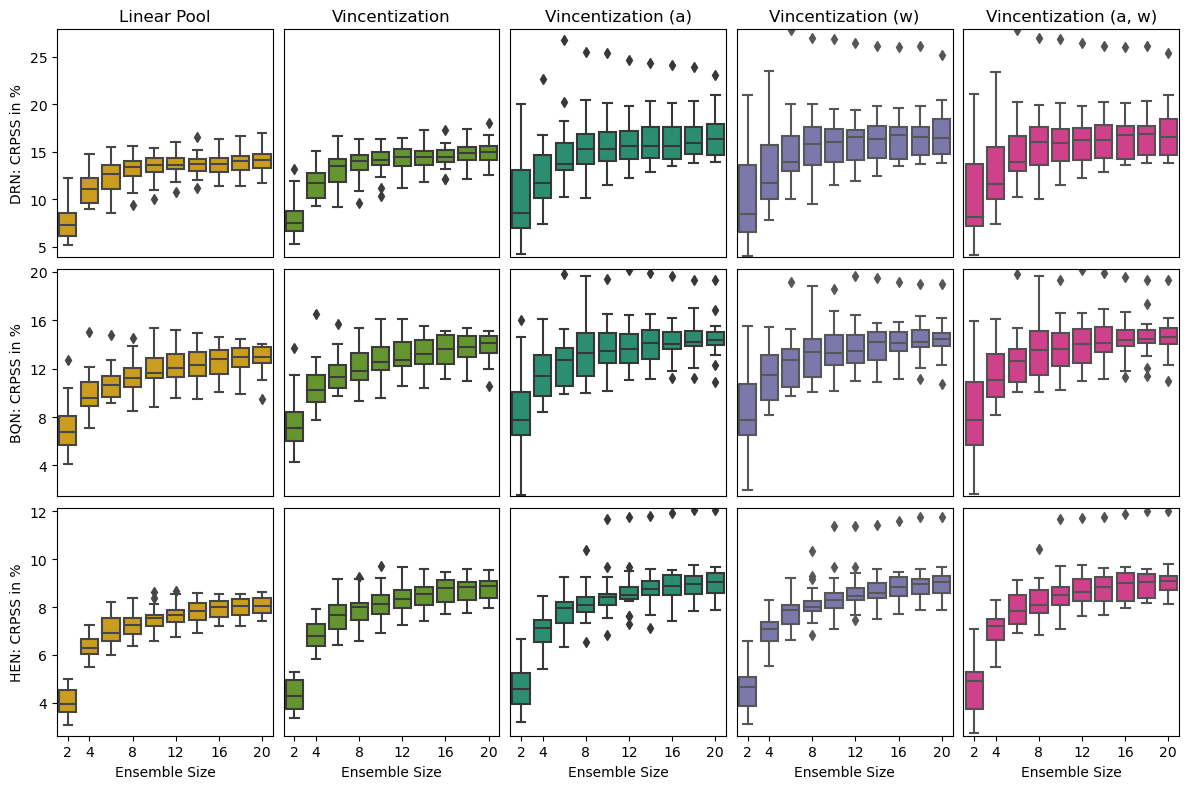

In [9]:
def plot_panel_boxplot():
    ### Get CONFIG information ###
    (
        _,
        _,
        plot_path,
        _,
        _,
        _,
        _,
        _,
        _,
        n_ens_vec,
        nn_vec,
    ) = _get_config_info(ens_method=ens_method)

    ### Initialization ###
    # Only scenario
    df_sc = df_scores[df_scores["model"] == dataset]

    ### Calculate quantities ###
    # Dataframe for plotting
    df_plot = pd.DataFrame()

    # For-Loop over network variants, ensemble sizes and aggregation methods
    for temp_nn in nn_vec:
        for i_ens in n_ens_vec:
            for temp_agg in agg_meths:
                # Get subset of scores data
                df_sub = df_sc[
                    (df_sc["n_ens"] == i_ens)
                    & (df_sc["type"] == temp_agg)
                    & (df_sc["nn"] == temp_nn)
                ]

                # New row for dataframe
                new_row = {
                    "n_ens": i_ens,
                    "nn": temp_nn,
                    "agg": temp_agg,
                    "crpss": [list(100 * df_sub["crpss"])],
                }
                df_plot = pd.concat(
                    [df_plot, pd.DataFrame(new_row, index=[0])],
                    ignore_index=True,
                )

    ### Prepare data ###
    # Rename networks
    df_plot["nn"] = df_plot["nn"].str.upper()

    ### PDF ###
    # Make plot
    fig, axes = plt.subplots(
        len(nn_vec),
        len(agg_names.keys()),
        figsize=(12, 8),
        squeeze=False,
    )

    # For-Loop over networks
    for i, temp_nn in enumerate([x.upper() for x in nn_vec]):
        # Get y-limits
        y_lim = df_plot[df_plot["nn"] == temp_nn].explode(column="crpss", ignore_index=True)["crpss"].agg(['min', 'max']) + (-0.1, 0.1)

        # For-Loop over metrics
        for j, agg_method in enumerate(agg_names.keys()):
            # Create boxplots
            sns.boxplot(
                data=df_plot[
                    (df_plot["nn"] == temp_nn)
                    & (df_plot["agg"] == agg_method)
                ].explode(
                    column="crpss"  # type: ignore
                ),
                y="crpss",
                x="n_ens",
                color=agg_col[agg_method],
                ax=axes[i][j],
            )

            # No skill
            axes[i][j].axhline(y=0, color="grey", linestyle="dashed")
            
            # y-limits
            axes[i][j].set(ylim=y_lim)
            
            # Method title
            if i == 0:
                axes[i][j].set_title(agg_names[agg_method])
            
            # x-label
            if i == (len(nn_vec)-1):
                axes[i][j].set_xlabel("Ensemble Size")
            else:
                axes[i][j].set_xlabel("")

            # y-label
            if j == 0:
                axes[i][j].set_ylabel(f"{temp_nn}: CRPSS in %")
            else:
                axes[i][j].set_ylabel("")

            # Set decimals
            axes[i][j].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

            # Set number of ticks
            axes[i][j].yaxis.set_major_locator(MaxNLocator(nbins=5))
            
            # # Set x-ticks
            axes[i][j].set_xticks([0, 1, 3, 5, 7, 9])      
            axes[i][j].set_xticklabels(["2", "4", "8", "12", "16", "20"])
            
            # Omit ticks
            if i != (len(nn_vec) - 1):
                axes[i][j].set_xticks([])
            if j != 0:
                axes[i][j].set_yticks([])

    # Optimize layout automatically
    plt.tight_layout()

    # Adjust horizontal/vertical spaces in subplot
    plt.subplots_adjust(wspace=0.05)
    plt.subplots_adjust(hspace=0.05)
    
    # Show plot
    plt.show()

    # Save fig
    filename = os.path.join(plot_path, f"{dataset}_{ens_method}_crpss_boxplots.pdf")
    fig.savefig(filename)
    plt.close(fig)

# Execute
plot_panel_boxplot()

### Boston - Bagging

Get configuration data

In [10]:
(
        ens_method,
        ens_method_ls,
        plot_path,
        data_path,
        data_ens_path,
        data_agg_path,
        dataset_ls,
        n_sim,
        n_ens,
        n_ens_vec,
        # nn_deep_arch,
        # nn_deep_arch_str,
        nn_vec,
    ) = _get_config_info(ens_method="bagging")

In [11]:
# Get exemplary score file
dataset = "boston"
ens_method = "bagging"

# Replace ensemble method (required as data_path depends on last ens. method called)
for temp_ens_method in ens_method_ls:
    data_path = data_path.replace(temp_ens_method, ens_method)

# Load scores
filename = f"eval_{dataset}_{ens_method}.pkl"
temp_data_path = data_path.replace("dataset", dataset)
with open(os.path.join(temp_data_path, filename), "rb") as f:
    df_scores = pickle.load(f) 

Generate score panel (based on function initiated for Kin8nm)

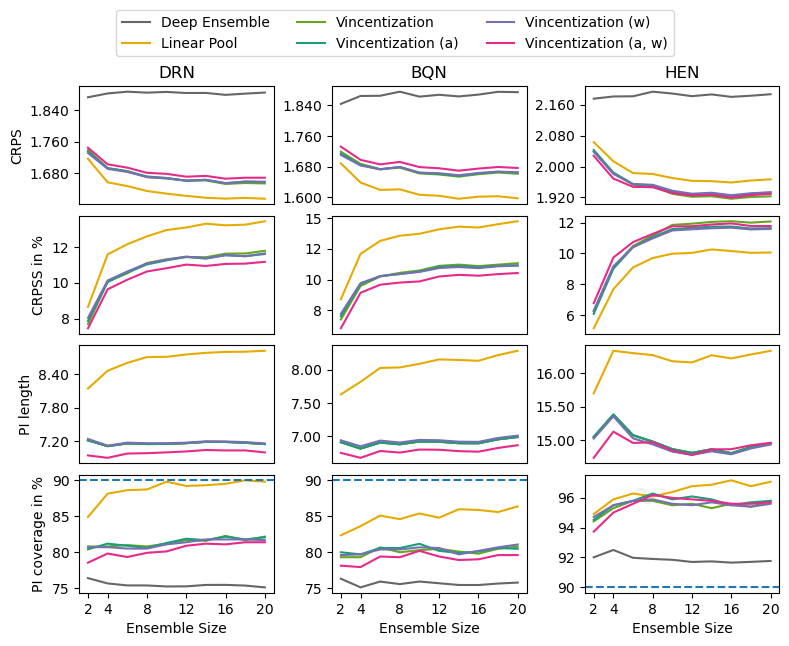

In [12]:
# Execute
plot_panel_model(
        crps_tick = 3,
        crpss_tick = 0,
        lgt_tick = 2,
        cov_tick = 0,
        y_bins = 4,
)

Generate PIT histograms (based on function initiated for Kin8nm)

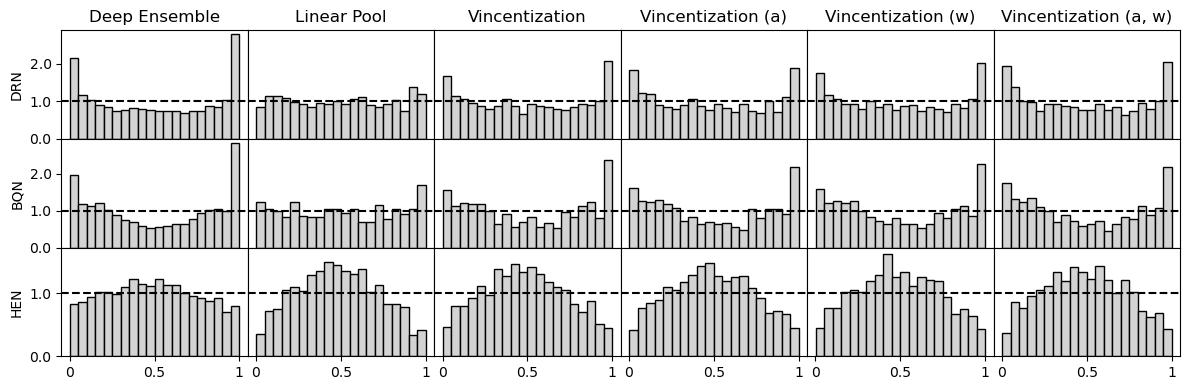

In [13]:
# Execute
plot_pit_ens()